Part II – Predictive Data Modelling (60 points)

Given the Housing Price Train dataset (Housing Price Prediction_Train.csv), develop a model to predict the price in the test dataset (Housing Price Prediction_Test.csv), and present your results in Housing Price Prediction_Result.csv. 

You will be evaluated in terms of your

|Criteria | Description | Points
-|-|-
|Data Engineering Approach | how to deal with missing value, categorical data, data skewness | 24 points
|Prediction Model | feature selection, model selection, model parameter optimization, evaluation metrics | 24 points
|Result Presentation | | 12 points


Upload your Housing Price Prediction_Result.csv together with your data processing document (ppt or excel or jupyter notebook) in a zip file for evaluation

We first load the required modules and the dataset

In [1]:
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedKFold, KFold

import lightgbm as lgb

# so that we can print multiple dataframe in the same cell
from IPython.display import display, HTML
def displayer(df): display(HTML(df.head(2).to_html()))
pd.set_option('display.max_columns', 500)

In [2]:
train_data_num = pd.read_csv("../input/housing/Housing_Price_Prediction_Train.csv")
test_data_num = pd.read_csv("../input/housing/Housing_Price_Prediction_Test.csv")
print(train_data_num.shape)
print(test_data_num.shape)
displayer(train_data_num)
displayer(test_data_num)
# train_labels.shape

(29999, 19)
(2999, 18)


,url,id,tradeTime,DOM,followers,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,price
0,https://bj.lianjia.com/chengjiao/101084782030.html,1.010000e+11,8/9/2016,1464,106,131.00,2,1,1,1,1.0,3,6,0.217,1,0,1,7,31680
1,https://bj.lianjia.com/chengjiao/101086012217.html,1.010000e+11,7/28/2016,903,126,132.38,2,2,1,2,1.0,4,6,0.667,1,1,0,7,43436


,url,id,tradeTime,DOM,followers,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district
0,https://bj.lianjia.com/chengjiao/BJCY87323610.html,BJCY87323610,7/30/2014,NaN,7,145.37,3,2,1,2,3.0,1,6,0.667,1,1,0,7
1,https://bj.lianjia.com/chengjiao/BJCY87323675.html,BJCY87323675,6/13/2015,1.0,21,144.90,3,2,1,2,1.0,1,6,0.375,1,1,1,7


In [3]:
# drop labels here
train_labels = train_data_num["price"]
train_data_num = train_data_num.drop(["price"], axis=1)
test_data_num.columns

Index(['url', 'id', 'tradeTime', 'DOM', 'followers', 'square', 'livingRoom',
       'drawingRoom', 'kitchen', 'bathRoom', 'buildingType',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'district'],
      dtype='object')

# Data Engineering
> Data Engineering Approach (how to deal with missing value, categorical data, data skewness)

First we remove values we do not think is relevant to our prediction, the URL and ID.

We might be processing the tradeTime later.

In [4]:
considered_columns = ['DOM', 'followers', 'square', 'livingRoom',
       'drawingRoom', 'kitchen', 'bathRoom', 'buildingType',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'district']
train_data_num = train_data_num[considered_columns]
test_data_num = test_data_num[considered_columns]

## Missing Values
We visualise the amount of NaN. We see that in the test data has very high percentage of NaNs for DOM. 

Therefore we should drom DOM from both the test data and training data.

The percentage NaN of buildingType is lower for the test set, so it should not be a problem.

In [5]:
df_eda = pd.DataFrame()
df_eda["train_total_na"] = train_data_num.isnull().sum()
df_eda["test_total_na"] = test_data_num.isnull().sum()
df_eda["train_percent_na"] = train_data_num.isnull().sum()/train_data_num.shape[0]*100
df_eda["test_percent_na"] = test_data_num.isnull().sum()/test_data_num.shape[0]*100
df_eda

,train_total_na,test_total_na,train_percent_na,test_percent_na
DOM,0,2456,0.000000,81.893965
followers,0,0,0.000000,0.000000
square,0,0,0.000000,0.000000
livingRoom,0,0,0.000000,0.000000
drawingRoom,0,0,0.000000,0.000000
kitchen,0,0,0.000000,0.000000
bathRoom,0,0,0.000000,0.000000
buildingType,272,16,0.906697,0.533511
renovationCondition,0,0,0.000000,0.000000
buildingStructure,0,0,0.000000,0.000000


In [6]:
train_data_num = train_data_num.drop(['DOM'], axis=1)
test_data_num = test_data_num.drop(['DOM'], axis=1)

## Distribution Analysis
We analyse the distribution to visualise what affects the price.

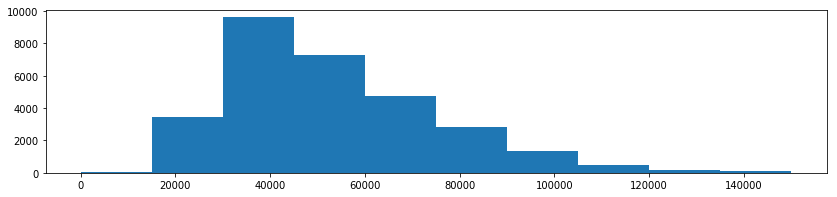

In [8]:
# Visualising prices
plt.figure(figsize=(14,3))
plt.hist(list(train_labels))
plt.show()

In [27]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
cmap = cm.plasma
norm = Normalize(vmin=0, vmax=100000)
colormap = cmap(norm(list(train_labels)[:100]))

We will not plot this a very beautiful scatterplot matrix to visualise the relationship between characterisitics.

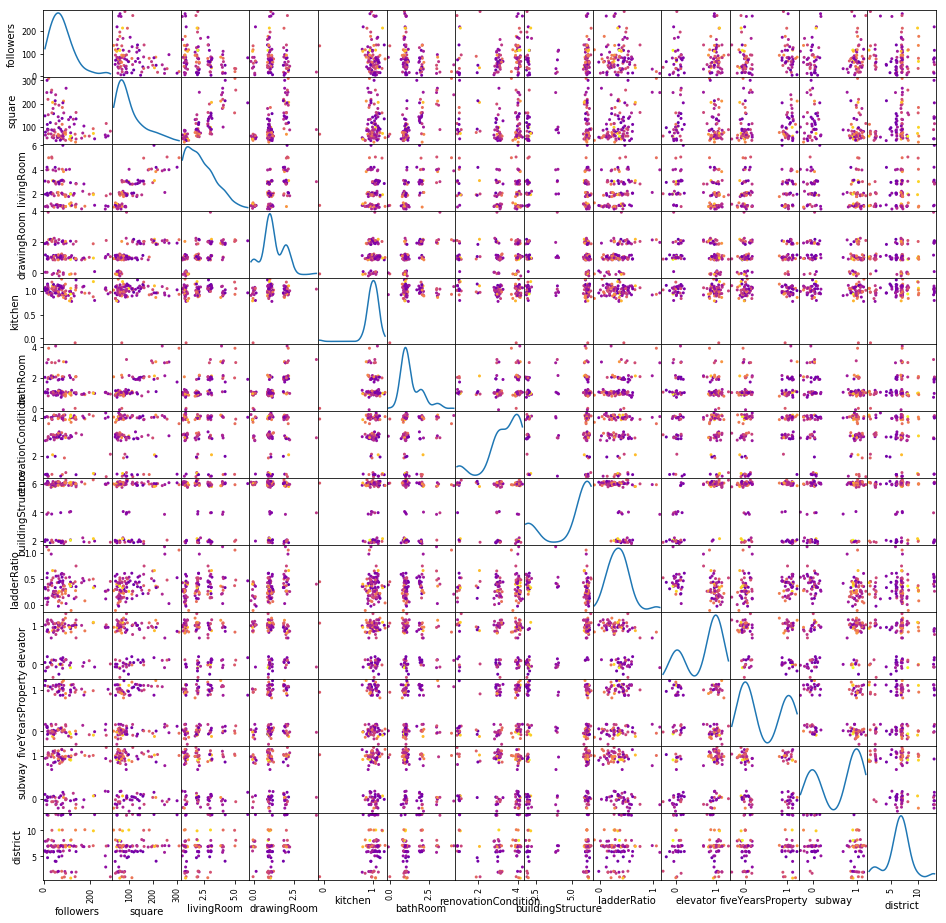

In [28]:
from pandas.plotting import scatter_matrix
df_plot = train_data_num.head(100)
df_plot = df_plot.applymap(lambda x: x + np.random.randn()/10.)
scatter_matrix(df_plot[['followers', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
               'bathRoom', 'renovationCondition', 'buildingStructure',
               'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway', 'district']], alpha = 1., 
               figsize = (16, 16), diagonal = 'kde', color = colormap)
plt.show()

## Categorical features
Now we define identify the categorical features from what we see in the scatter plot.


In [10]:
categorical_features = ['livingRoom', 'drawingRoom', 'kitchen', 'bathRoom',
       'renovationCondition', 'buildingStructure', 'elevator',
       'fiveYearsProperty', 'subway', 'district']

# Prediction Model
> Prediction Model (feature selection, model selection, model parameter optimization, evaluation metrics

We will use LightGBM. LightGBM is fast and powerful, and is the basis of many solution online.

We first define transform the dataset LightGBM compatible format. Some columns are casted categorical as recognised previously.

In [11]:
train_dataset = lgb.Dataset(train_data_num, label=train_labels,
                            free_raw_data=False,
                            categorical_feature=categorical_features)
test_dataset = lgb.Dataset(test_data_num, label=train_labels,
                           free_raw_data=False,
                           categorical_feature=categorical_features)

We do Kfold cross validation to create maximise the data used to train the model

In [12]:
num_rows = train_labels.shape[0]
skf = KFold(n_splits=10, shuffle=True, random_state=42)
folds = [fold for fold in skf.split(np.arange(num_rows), train_labels)]

These parameters are selected because it gave the best results. 

In [13]:
param = {'num_leaves': 127, 
         'objective': 'regression',
         'early_stopping_round': 10,  # early stopping to prevent overfitting on the training data
         'verbose_eval': -1,
         'verbose': -1}
num_round = 200

In [14]:
bst_lst = []
for i, (tr_idx, tx_idx) in enumerate(folds):
    print("fold number ", i)
    bst = lgb.train(param,
                    train_dataset.subset(tr_idx).construct(), 
                    num_round,
                    categorical_feature=categorical_features,
                    valid_sets=train_dataset.subset(tx_idx).construct())
    bst_lst.append(bst)

fold number  0
[1]	valid_0's l2: 4.29417e+08
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 3.77428e+08
[3]	valid_0's l2: 3.35143e+08
[4]	valid_0's l2: 3.00528e+08
[5]	valid_0's l2: 2.7242e+08
[6]	valid_0's l2: 2.50014e+08
[7]	valid_0's l2: 2.31109e+08
[8]	valid_0's l2: 2.15625e+08
[9]	valid_0's l2: 2.03272e+08


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's l2: 1.92882e+08
[11]	valid_0's l2: 1.84425e+08
[12]	valid_0's l2: 1.77035e+08
[13]	valid_0's l2: 1.71451e+08
[14]	valid_0's l2: 1.66724e+08
[15]	valid_0's l2: 1.62531e+08
[16]	valid_0's l2: 1.5949e+08
[17]	valid_0's l2: 1.56796e+08
[18]	valid_0's l2: 1.5422e+08
[19]	valid_0's l2: 1.52345e+08
[20]	valid_0's l2: 1.5088e+08
[21]	valid_0's l2: 1.49218e+08
[22]	valid_0's l2: 1.48216e+08
[23]	valid_0's l2: 1.4719e+08
[24]	valid_0's l2: 1.46392e+08
[25]	valid_0's l2: 1.45535e+08
[26]	valid_0's l2: 1.44856e+08
[27]	valid_0's l2: 1.44136e+08
[28]	valid_0's l2: 1.43861e+08
[29]	valid_0's l2: 1.43356e+08
[30]	valid_0's l2: 1.42966e+08
[31]	valid_0's l2: 1.42706e+08
[32]	valid_0's l2: 1.42098e+08
[33]	valid_0's l2: 1.41494e+08
[34]	valid_0's l2: 1.41315e+08
[35]	valid_0's l2: 1.41097e+08
[36]	valid_0's l2: 1.4095e+08
[37]	valid_0's l2: 1.40807e+08
[38]	valid_0's l2: 1.40593e+08
[39]	valid_0's l2: 1.40181e+08
[40]	valid_0's l2: 1.39953e+08
[41]	valid_0's l2: 1.39718e+08
[42]	valid_0'

[68]	valid_0's l2: 1.27361e+08
Early stopping, best iteration is:
[58]	valid_0's l2: 1.27324e+08
fold number  3
[1]	valid_0's l2: 4.2479e+08
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 3.71707e+08
[3]	valid_0's l2: 3.27947e+08
[4]	valid_0's l2: 2.93034e+08
[5]	valid_0's l2: 2.64193e+08
[6]	valid_0's l2: 2.4055e+08
[7]	valid_0's l2: 2.21243e+08
[8]	valid_0's l2: 2.05526e+08
[9]	valid_0's l2: 1.92823e+08
[10]	valid_0's l2: 1.82317e+08
[11]	valid_0's l2: 1.73968e+08
[12]	valid_0's l2: 1.66727e+08
[13]	valid_0's l2: 1.60863e+08
[14]	valid_0's l2: 1.56137e+08
[15]	valid_0's l2: 1.52111e+08
[16]	valid_0's l2: 1.4874e+08
[17]	valid_0's l2: 1.45607e+08
[18]	valid_0's l2: 1.43405e+08
[19]	valid_0's l2: 1.41397e+08
[20]	valid_0's l2: 1.3996e+08
[21]	valid_0's l2: 1.38477e+08
[22]	valid_0's l2: 1.37013e+08
[23]	valid_0's l2: 1.36048e+08
[24]	valid_0's l2: 1.34898e+08
[25]	valid_0's l2: 1.34146e+08
[26]	valid_0's l2: 1.33323e+08
[27]	valid_0's l2: 1.32717e+08
[2

fold number  6
[1]	valid_0's l2: 4.00432e+08
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 3.51149e+08
[3]	valid_0's l2: 3.10756e+08
[4]	valid_0's l2: 2.78405e+08
[5]	valid_0's l2: 2.52114e+08
[6]	valid_0's l2: 2.3098e+08
[7]	valid_0's l2: 2.13658e+08
[8]	valid_0's l2: 1.99565e+08
[9]	valid_0's l2: 1.87935e+08
[10]	valid_0's l2: 1.78649e+08
[11]	valid_0's l2: 1.70918e+08
[12]	valid_0's l2: 1.64816e+08
[13]	valid_0's l2: 1.59656e+08
[14]	valid_0's l2: 1.55247e+08
[15]	valid_0's l2: 1.51916e+08
[16]	valid_0's l2: 1.49045e+08
[17]	valid_0's l2: 1.46513e+08
[18]	valid_0's l2: 1.44671e+08
[19]	valid_0's l2: 1.43124e+08
[20]	valid_0's l2: 1.41645e+08
[21]	valid_0's l2: 1.40542e+08
[22]	valid_0's l2: 1.39529e+08
[23]	valid_0's l2: 1.38736e+08
[24]	valid_0's l2: 1.37964e+08
[25]	valid_0's l2: 1.37273e+08
[26]	valid_0's l2: 1.36891e+08
[27]	valid_0's l2: 1.36593e+08
[28]	valid_0's l2: 1.36167e+08
[29]	valid_0's l2: 1.35832e+08
[30]	valid_0's l2: 1.35502e+08
[31

[50]	valid_0's l2: 1.21105e+08
[51]	valid_0's l2: 1.20955e+08
[52]	valid_0's l2: 1.20926e+08
[53]	valid_0's l2: 1.20626e+08
[54]	valid_0's l2: 1.20606e+08
[55]	valid_0's l2: 1.20549e+08
[56]	valid_0's l2: 1.20373e+08
[57]	valid_0's l2: 1.2029e+08
[58]	valid_0's l2: 1.20249e+08
[59]	valid_0's l2: 1.20152e+08
[60]	valid_0's l2: 1.20003e+08
[61]	valid_0's l2: 1.20096e+08
[62]	valid_0's l2: 1.1988e+08
[63]	valid_0's l2: 1.19737e+08
[64]	valid_0's l2: 1.19717e+08
[65]	valid_0's l2: 1.19648e+08
[66]	valid_0's l2: 1.19601e+08
[67]	valid_0's l2: 1.19452e+08
[68]	valid_0's l2: 1.19318e+08
[69]	valid_0's l2: 1.19357e+08
[70]	valid_0's l2: 1.19346e+08
[71]	valid_0's l2: 1.19362e+08
[72]	valid_0's l2: 1.19206e+08
[73]	valid_0's l2: 1.19182e+08
[74]	valid_0's l2: 1.19128e+08
[75]	valid_0's l2: 1.1915e+08
[76]	valid_0's l2: 1.19078e+08
[77]	valid_0's l2: 1.19055e+08
[78]	valid_0's l2: 1.18931e+08
[79]	valid_0's l2: 1.18881e+08
[80]	valid_0's l2: 1.1882e+08
[81]	valid_0's l2: 1.18751e+08
[82]	valid_0

In [15]:
print(sum(list(train_labels))/len(train_labels))

53165.76092536418


We can see the the loss is around 10^8. This is a very reasonable estiamate considering the distribution of prices, with the average at 53165.

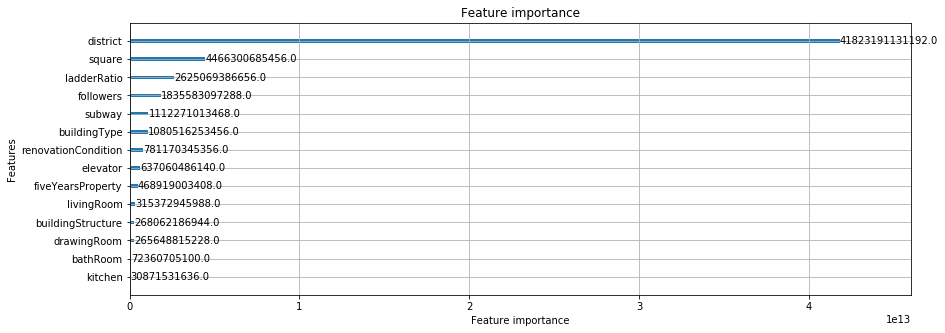

In [16]:
lgb.plot_importance(bst, importance_type="gain", figsize=(14,5))

From the above, we see that the district is the most important measure of the price of the house. The next important feature is square.

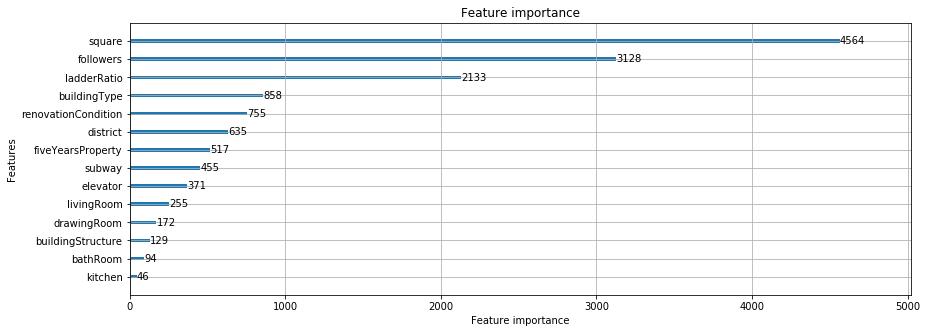

In [17]:
lgb.plot_importance(bst, importance_type="split", figsize=(14,5))

Information on the apartment size (area) and the "ladder" ratio helps to fine tune the prediction of the housing prices.

In summary, we argue that the price is first determined by the district. Then the result is fine tuned with "square" and "ladder".

We now predict for the test set.

In [18]:
preds = []
for bst in bst_lst:
    pred = bst.predict(test_data_num) # not test_dataset
    preds.append(pred)
preds = np.array(preds)
print(preds.shape)

preds_mean = np.mean(preds, axis=0)
print(preds_mean.shape)

(10, 2999)
(2999,)


In [19]:
test_data_num["price"] = preds_mean
test_data_num.head()
test_data_num.to_csv("Price Prediction_Result.csv")